In [1]:
import numpy as np
import pandas as pd
import sklearn as skl

df = pd.read_csv("C:/Users/gille/Desktop/Machine learning/Opdracht/music_genre.csv")
df.columns

seed = 42
np.random.seed(seed)

# Preprocessing the data

Before we can get to work testing models we have to clean up our data by dropping irrelevant columns and transforming the non-numerical ones.<br />
First let's remove the columns we will not need and find out which columns are non numerical. 

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("C:/Users/gille/Desktop/Machine learning/Opdracht/music_genre.csv")

# Silently remove the 4 rows with all nan values
df = df.dropna(how='all')

# First let's do something about the tempo which is just non numerical because NaN values are instead given the value '?'
df.tempo = df.tempo.replace('?', np.NaN).astype('float64')

# Same for the '-1' values in duration_ms:
df.duration_ms = df.duration_ms.replace(-1.0, np.nan)

# Remove non significant columns
X = df.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)

# Select target prediction data
y = df.music_genre

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = seed)

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)


Categorical variables:
['key', 'mode']


Next let's do something about the 'mode' column. This column only contains values 'Minor' and 'Major'. We can simply replace those by 0 and 1 to create a binary map that the models can use:

In [3]:
df = df.replace('Minor', 0)
df = df.replace('Major', 1)

Key can be any letter A-G with or without a hashtag, this corresponds with 12 possible values (B and E only occur without the hashtag). Genre is the column we are trying to predict, it contains one of 10 genres. We now have to choose between ordinal encoding or one-hot encoding for these columns. Ordinal column may be meaningful for key but for genre this seems to be less logical. We will however use ordinal encoding for both columns because of the added entries when using one-hot encoding for columns with a higher cardinality.

In [4]:
from sklearn.preprocessing import LabelEncoder

key_encoder = LabelEncoder()
df.key = key_encoder.fit_transform(df.key)

genre_encoder = LabelEncoder()
df.music_genre = genre_encoder.fit_transform(df.music_genre)

# Remove non significant columns
X = df.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)

# Select target prediction data
y = df.music_genre

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = seed)

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
[]


All that is left to do now is determine how to handle the missing values for duration and tempo, but we will decide this later for every model based on what method performs better.

# Finding the right model

We prepare for our search by writing a function that will help us decide which models and features perform best. We chose to base our scoring on the model.score finction since calculating the mean average error takes quite some time and the model.score function seems to give a better indication of how good our model is.


In [5]:
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# a function to test our features and models against each other
def test_usability_parameters(X_valid, X_training, y_valid, y_training, relevant_features, model):
    
    X_v = X_valid[relevant_features]
    X_t = X_training[relevant_features]
    
    # Fit the model
    
    model.fit(X_t, y_training)
    predictions = model.predict(X_v)
    
    score = model.score(X_v, y_valid)
    
    #val_acc = accuracy_score(y_valid, predictions)

    # following line to see the validation_mae
    # print(', '.join(relevant_features) + ':' + str(val_mae))
    
    return score

## Attempt 1: Random forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=seed, n_jobs=-1)
# n_jobs allows the use of multiple threads/cores to speed up calculations

### Missing value handling
As mentioned before we still have to decide how to handle missing values.

In [7]:
# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column>0])

duration_ms    3699
tempo          3749
dtype: int64


We still have about 3700 missing values for both duration and tempo. This could mean a loss of up to 20% of our data if we would just drop all rows with missing values. Let's find out what's the best course of action: dropping columns, dropping rows or using an imputer.

In [8]:
# First lets try dropping columns
cols_without_missing = [col for col in X_train.columns
                     if X_train[col].notnull().all()]


test_usability_parameters(X_val, X_train, y_val, y_train, cols_without_missing, model)

0.5336

In [9]:
# Next let's try removing all NaN containing rows
df_nonan = df.dropna()

# Remove non significant columns
X_nonan = df_nonan.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)

# Select target prediction data
y_nonan = df_nonan.music_genre

X_t, X_v, y_t, y_v = train_test_split(X_nonan, y_nonan, random_state = seed)

test_usability_parameters(X_v, X_t, y_v, y_t, X_v.columns, model)

0.5517751479289941

In [10]:
from sklearn.impute import SimpleImputer

# Imputation
final_imputer = SimpleImputer(strategy='median')
final_X_train = pd.DataFrame(final_imputer.fit_transform(X_train))
final_X_valid = pd.DataFrame(final_imputer.transform(X_val))

# Imputation removed column names; put them back
final_X_train.columns = X_train.columns
final_X_valid.columns = X_val.columns

test_usability_parameters(final_X_valid, final_X_train, y_val, y_train, cols_without_missing, model)

0.5336

In [11]:
# Imputation
final_imputer = SimpleImputer(strategy='mean')
final_X_train = pd.DataFrame(final_imputer.fit_transform(X_train))
final_X_valid = pd.DataFrame(final_imputer.transform(X_val))

# Imputation removed column names; put them back
final_X_train.columns = X_train.columns
final_X_valid.columns = X_val.columns

test_usability_parameters(final_X_valid, final_X_train, y_val, y_train, cols_without_missing, model)

0.5336

In [12]:
# Imputation
final_imputer = SimpleImputer(strategy='most_frequent')
final_X_train = pd.DataFrame(final_imputer.fit_transform(X_train))
final_X_valid = pd.DataFrame(final_imputer.transform(X_val))

# Imputation removed column names; put them back
final_X_train.columns = X_train.columns
final_X_valid.columns = X_val.columns

test_usability_parameters(final_X_valid, final_X_train, y_val, y_train, cols_without_missing, model)

0.5336

We see that even though some data will get lost, deleting the rows with the missing values gives the best results. From now on we will us this method to handle our missing values for this model.

In [13]:
# Remove all NaN containing rows
df_nonan = df.dropna()

# Remove non significant columns
X_nonan = df_nonan.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)

# Select target prediction data
y_nonan = df_nonan.music_genre

X_train, X_val, y_train, y_val = train_test_split(X_nonan, y_nonan, random_state = seed)

### Feature picking

#### Removing one feature
First we will take a look at how each feature influences our results, are some better off ignored?

In [14]:
model = RandomForestClassifier(criterion='entropy', random_state=seed, n_jobs=-1)

In [15]:
columns = X_train.columns

data = pd.DataFrame({"feature": [],"Value": [],},)

for f in columns:
    feature = [f]
    X_temp = X_train.drop(feature, axis=1)
    columns_temp = X_temp.columns
    val = test_usability_parameters(X_val, X_train, y_val, y_train, columns_temp, model)
    #print(val)
    data = data.append(pd.DataFrame({"feature": feature,"Value": [val],},))


data.sort_values(by=['Value'], ascending=False).head()

,feature,Value
0,energy,0.553945
0,key,0.551874
0,mode,0.551479
0,liveness,0.550690
0,tempo,0.547337


We can see that removing the energy column results in a slightly better score, all other changes seem to make the model worse or barely change the outcome.

#### Two features
Now for 2 features every time. To limit the execution time to less then an hour we only try removing energy along with one other feature each time:

In [16]:
data = pd.DataFrame({"features": [],"Value": [],},)


f1 = 'energy'
for j in range(len(columns)):
    if columns[j] != f1:
        f2 = columns[j]
        features = [f1, f2]
        X_temp = X_train.drop(features, axis=1)
        columns_temp = X_temp.columns
        val = test_usability_parameters(X_val, X_train, y_val, y_train, columns_temp, model)
        #print(val)
        data = data.append(pd.DataFrame({"features": [features],"Value": [val],},))

data.sort_values(by=['Value'], ascending=False).head()
    

,features,Value
0,"[energy, key]",0.553748
0,"[energy, liveness]",0.551874
0,"[energy, mode]",0.549310
0,"[energy, tempo]",0.547929
0,"[energy, loudness]",0.539250


As expected no improvement occurs. We will therefore only remove the 'energy' column for the sole purpose of keeping the model as simple as possible and the slight improvement.  

In [17]:
X_train_final = X_train.drop(['energy'], axis=1)
X_val_final = X_val.drop(['energy'], axis=1) 

columns = X_train_final.columns

### Selecting a criterion
For our random forest classification model the criterion decides how the best split is selected. The default criterion is entropy but we can still try the other option:

In [18]:
model = RandomForestClassifier(criterion='entropy', random_state=seed, n_jobs=-1)
test_usability_parameters(X_val_final, X_train_final, y_val, y_train, columns, model)

0.5539447731755424

In [19]:
model = RandomForestClassifier(criterion='gini' , random_state=seed, n_jobs=-1)
test_usability_parameters(X_val_final, X_train_final, y_val, y_train, columns, model)

0.5551282051282052

The gini criterion slightly outperforms the entropy criterion. We will be using the gini criterion.

### Forest size
As another attempt to improve our random forest model we will try to play around with some different values for 'n_estimators'.

In [20]:
data = pd.DataFrame({"n_estimators": [],"Value": [],},)

for i in range(10,300,10):
    model = RandomForestClassifier(criterion='gini', n_estimators=i, random_state=seed, n_jobs=-1)
    
    val = test_usability_parameters(X_val_final, X_train_final, y_val, y_train, columns, model)
    #print(val)
    data = data.append(pd.DataFrame({"n_estimators": [i],"Value": [val],},))

data.sort_values(by=['Value'], ascending=False).head(10)

,n_estimators,Value
0,180.0,0.557890
0,260.0,0.557791
0,120.0,0.557495
0,190.0,0.557396
0,210.0,0.557298
0,130.0,0.557101
0,140.0,0.557101
0,230.0,0.557002
0,270.0,0.556805
0,160.0,0.556607


<Figure size 432x288 with 0 Axes>

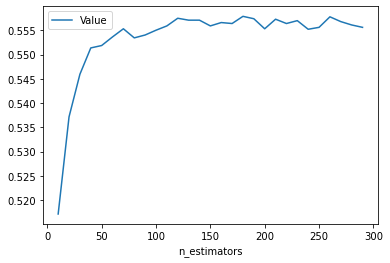

In [21]:
import matplotlib.pyplot as plt

plt.figure();
data.plot(x='n_estimators',y='Value');
plt.savefig("n_estimators.png")

We see the score reach somewhat of a high at n_estimators=120. After that it varies slightly, seemingly improving little by little. As the number of estimators rises so does the time needed to calculate everything. The best course of action therefore seems to be to keep n_estimators=120.

### Maximum depth of trees
Another parameter that could influence the accuracy of our model is the maximum depth of trees. Let's play around with some values to see if there is any improvement.

In [22]:
data = pd.DataFrame({"max_depth": [],"Value": [],},)

for i in range(1,20):
    model = RandomForestClassifier(max_depth=i, criterion='gini', n_estimators=120, random_state=seed, n_jobs=-1)
    
    val = test_usability_parameters(X_val_final, X_train_final, y_val, y_train, columns, model)
    #print(val)
    data = data.append(pd.DataFrame({"max_depth": [i],"Value": [val],},))

data.sort_values(by=['Value'], ascending=False).head(10)

,max_depth,Value
0,11.0,0.568639
0,9.0,0.568540
0,10.0,0.568146
0,13.0,0.566963
0,12.0,0.566371
0,16.0,0.564694
0,14.0,0.563314
0,8.0,0.561933
0,15.0,0.560552
0,17.0,0.560355


<Figure size 432x288 with 0 Axes>

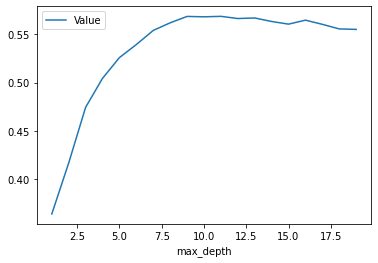

In [23]:
plt.figure();
data.plot(x='max_depth',y='Value');

We reach the best score at max_depth=11.

### Maximum features
Another parameter that could influence the accuracy of our model is the number of features to consider when looking for the best split. Let's see if we can improve on the default value.

In [24]:
data = pd.DataFrame({"max_features": [],"Value": [],},)

for i in range(1,13):
    model = RandomForestClassifier(max_depth=11, criterion='gini', n_estimators=120, max_features=i , random_state=seed, n_jobs=-1)
    
    val = test_usability_parameters(X_val_final, X_train_final, y_val, y_train, columns, model)
    #print(val)
    data = data.append(pd.DataFrame({"max_features": [i],"Value": [val],},))

data.sort_values(by=['Value'], ascending=False).head(10)

,max_features,Value
0,6.0,0.570118
0,3.0,0.568639
0,4.0,0.567456
0,5.0,0.567160
0,9.0,0.564892
0,2.0,0.564694
0,8.0,0.564398
0,7.0,0.563314
0,11.0,0.561736
0,10.0,0.560750


<Figure size 432x288 with 0 Axes>

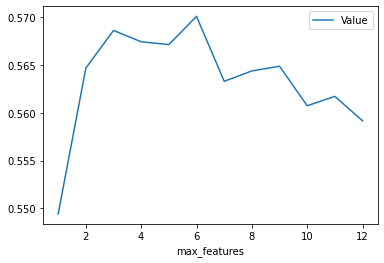

In [25]:
plt.figure();
data.plot(x='max_features',y='Value');

We could go on and play around with all the different parameters of the random tree regression model, but since we only have a score of around 0.6 at this point it is highly unlikely a decent model will be found this way.
In conclusion we can say that even though there were improvements, this model appears to be unable to accurately predict the genre of a song based on the given features.<br />
<br />
In hindsight this was to be expected since we are using a general purpose model on a task that is known to be very hard and specific. For our next model we will try and find a more advanced model.

## Visualization of the result

In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

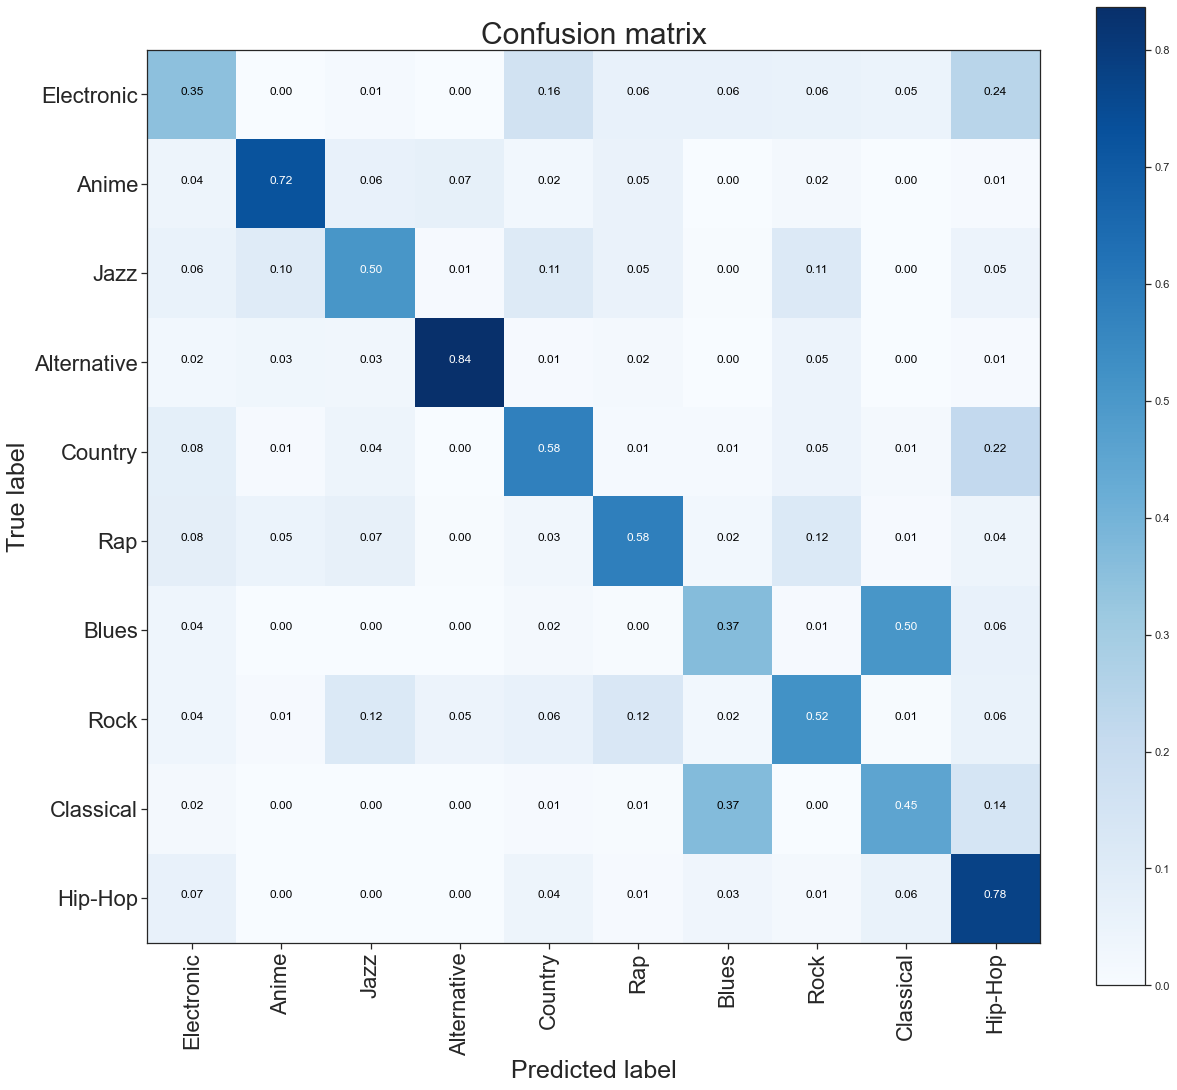

In [46]:
from sklearn.metrics import confusion_matrix

model = RandomForestClassifier(max_depth=11, criterion='gini', n_estimators=120, max_features=6 , random_state=seed, n_jobs=-1)

model.fit(X_train_final, y_train)
y_pred = model.predict(X_val_final)

cnf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(20,18))
plot_confusion_matrix(cnf_matrix, classes=genre_encoder.inverse_transform(df_nonan.music_genre.unique()), title="Confusion matrix")
plt.savefig('conf_matrix_RTC.png', bbox_inches="tight")